<a href="https://colab.research.google.com/github/yadavrishikesh/Deep-Learning-Slides-Code/blob/main/code/DL_OptimizationAlgorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary Classification and Optimization Algorithms Comparison

In this notebook, we will:

1. Simulate a synthetic binary classification dataset.
2. Implement logistic regression from scratch.
3. Train the model using several optimization algorithms:
   - Gradient Descent (GD)
   - Stochastic Gradient Descent (SGD)
   - Newton-Raphson
   - Adam
4. Compare convergence and final classification performance.

## 1. Import Libraries
We need `numpy` for numerical computations and `matplotlib` for plotting convergence.


In [15]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)  # ensure reproducibility


## 2. Generate Synthetic Binary Classification Data
We simulate two classes with 2D features. Each class is sampled from a Gaussian distribution.
We also add a bias term (intercept) to the feature matrix.


In [16]:
def generate_data(n_samples=20000, n_features=2):
    X_class0 = np.random.randn(n_samples//2, n_features) + np.array([0, 0])
    X_class1 = np.random.randn(n_samples//2, n_features) + np.array([2, 2])

    X = np.vstack([X_class0, X_class1])
    y = np.array([0]*(n_samples//2) + [1]*(n_samples//2))

    X = np.hstack([np.ones((n_samples,1)), X])  # add bias

    return X, y.reshape(-1,1)

X, y = generate_data()
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (20000, 3)
Shape of y: (20000, 1)


## 3. Logistic Regression: Loss and Gradients
We define:

- **Sigmoid function:** maps linear combination to probability.
- **Binary cross-entropy loss:** measures prediction error.
- **Gradient and Hessian:** required for GD and Newton-Raphson.


In [17]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def binary_cross_entropy(y_true, y_pred):
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1-eps)
    return -np.mean(y_true*np.log(y_pred) + (1-y_true)*np.log(1-y_pred))

def compute_gradient(X, y, w):
    y_pred = sigmoid(X @ w)
    return X.T @ (y_pred - y) / X.shape[0]

def compute_hessian(X, w):
    y_pred = sigmoid(X @ w)
    S = np.diag((y_pred*(1-y_pred)).flatten())
    return X.T @ S @ X / X.shape[0]


## 4. Optimization Algorithms

We implement four algorithms **from scratch**:

1. **Gradient Descent:** full-batch gradient update.
2. **Stochastic Gradient Descent (SGD):** updates on one sample at a time.
3. **Newton-Raphson:** uses second-order derivative (Hessian) for faster convergence.
4. **Adam:** combines momentum and adaptive learning rates.


In [18]:
import time  # for measuring execution time

# -----------------------------
# 4.1 Gradient Descent
# -----------------------------
def gradient_descent(X, y, lr=0.1, epochs=100):
    w = np.zeros((X.shape[1],1))
    loss_history = []
    start_time = time.time()  # start timer
    for i in range(epochs):
        grad = compute_gradient(X, y, w)
        w -= lr * grad
        loss_history.append(binary_cross_entropy(y, sigmoid(X @ w)))
    end_time = time.time()  # end timer
    elapsed = end_time - start_time
    return w, loss_history, elapsed

# -----------------------------
# 4.2 Stochastic Gradient Descent
# -----------------------------
def stochastic_gradient_descent(X, y, lr=0.1, epochs=100):
    w = np.zeros((X.shape[1],1))
    loss_history = []
    n_samples = X.shape[0]
    start_time = time.time()
    for i in range(epochs):
        indices = np.random.permutation(n_samples)
        X_shuffled, y_shuffled = X[indices], y[indices]
        for j in range(n_samples):
            x_i = X_shuffled[j].reshape(1,-1)
            y_i = y_shuffled[j].reshape(-1,1)
            w -= lr * compute_gradient(x_i, y_i, w)
        loss_history.append(binary_cross_entropy(y, sigmoid(X @ w)))
    end_time = time.time()
    elapsed = end_time - start_time
    return w, loss_history, elapsed

# -----------------------------
# 4.3 Newton-Raphson
# -----------------------------
def newton_raphson(X, y, epochs=10):
    w = np.zeros((X.shape[1],1))
    loss_history = []
    start_time = time.time()
    for i in range(epochs):
        grad = compute_gradient(X, y, w)
        H = compute_hessian(X, w)
        try:
            w -= np.linalg.inv(H) @ grad
        except np.linalg.LinAlgError:
            w -= grad
        loss_history.append(binary_cross_entropy(y, sigmoid(X @ w)))
    end_time = time.time()
    elapsed = end_time - start_time
    return w, loss_history, elapsed

# -----------------------------
# 4.4 Adam Optimizer
# -----------------------------
def adam(X, y, lr=0.1, epochs=100, beta1=0.9, beta2=0.999, eps=1e-8):
    w = np.zeros((X.shape[1],1))
    m = np.zeros_like(w)
    v = np.zeros_like(w)
    loss_history = []
    start_time = time.time()
    for t in range(1, epochs+1):
        grad = compute_gradient(X, y, w)
        m = beta1*m + (1-beta1)*grad
        v = beta2*v + (1-beta2)*(grad**2)
        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)
        w -= lr * m_hat / (np.sqrt(v_hat) + eps)
        loss_history.append(binary_cross_entropy(y, sigmoid(X @ w)))
    end_time = time.time()
    elapsed = end_time - start_time
    return w, loss_history, elapsed

## 5. Train All Algorithms and Compare Convergence
We will train all optimizers and plot the loss over epochs.


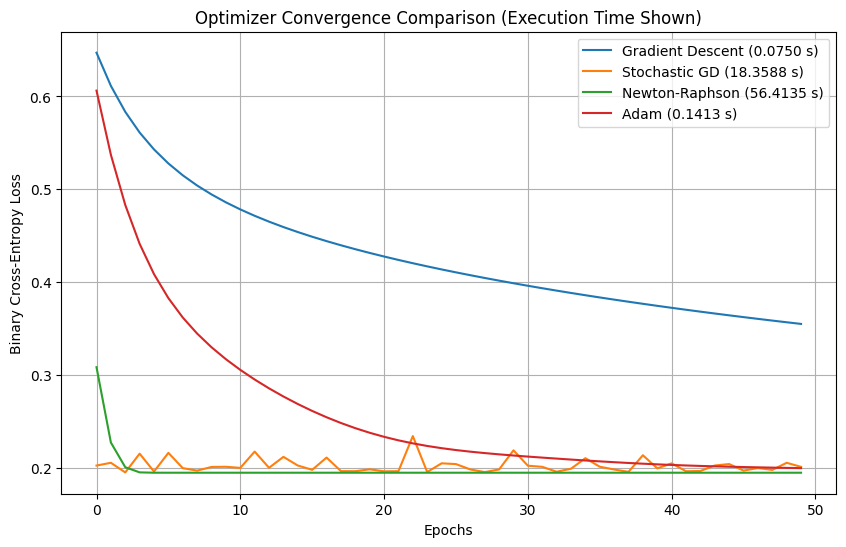

In [19]:
import time

# -----------------------------
# Train and record loss + time
# -----------------------------
epochs = 50

w_gd, loss_gd, time_gd = gradient_descent(X, y, lr=0.1, epochs=epochs)
w_sgd, loss_sgd, time_sgd = stochastic_gradient_descent(X, y, lr=0.1, epochs=epochs)
w_nr, loss_nr, time_nr = newton_raphson(X, y, epochs=epochs)
w_adam, loss_adam, time_adam = adam(X, y, lr=0.1, epochs=epochs)

# -----------------------------
# Plot convergence with time info
# -----------------------------
plt.figure(figsize=(10,6))

plt.plot(loss_gd, label=f'Gradient Descent ({time_gd:.4f} s)')
plt.plot(loss_sgd, label=f'Stochastic GD ({time_sgd:.4f} s)')
plt.plot(loss_nr, label=f'Newton-Raphson ({time_nr:.4f} s)')
plt.plot(loss_adam, label=f'Adam ({time_adam:.4f} s)')

plt.xlabel('Epochs')
plt.ylabel('Binary Cross-Entropy Loss')
plt.title('Optimizer Convergence Comparison (Execution Time Shown)')
plt.legend()
plt.grid(True)
plt.show()

## 6. Evaluate Accuracy

Finally, we check the **prediction accuracy** of each trained model on the training dataset.


In [20]:
def predict(X, w):
    return (sigmoid(X @ w) >= 0.5).astype(int)

def accuracy(X, y, w):
    return np.mean(predict(X, w) == y)

print("Accuracy GD:", accuracy(X, y, w_gd))
print("Accuracy SGD:", accuracy(X, y, w_sgd))
print("Accuracy Newton-Raphson:", accuracy(X, y, w_nr))
print("Accuracy Adam:", accuracy(X, y, w_adam))


Accuracy GD: 0.8598
Accuracy SGD: 0.9173
Accuracy Newton-Raphson: 0.92055
Accuracy Adam: 0.9195
